In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [159]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [5]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_lighting=0.15, max_zoom=1.5, max_warp=0.)

In [6]:
np.random.seed(42)

In [7]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

## Some dataset statistics

In [102]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [113]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
print('Hem IDs: ' + ' '.join(hem_patient_ids))
print("Count: {}".format(len(hem_patient_ids)))

Hem IDs: H14 H12 H24 H8 H6 H2 H7 H10 H1 H22 H5 H13 H23 H48 H4 H17 H15 H16 H19 H20 H9 H46 H18 H11 H40
Count: 25


In [114]:
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))
print('All IDs: ' + ' '.join(all_patint_ids))
print("Count: {}".format(len(all_patint_ids)))

All IDs: 37 52 72 43 47 30 48 13 20 46 50 67 22 51 11 28 34 26 75 74 78 27 19 45 17 68 31 4 16 5 23 1 14 15 35 3 18 49 21 36 38 32 24 44 33 2 25
Count: 47


In [116]:
hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]

print()

In [120]:
print('Hem Images Count: {}'.format(len([fn for fn in fnames if hem_regex.search(str(fn)) is not None])))
print('All Images Count: {}'.format(len([fn for fn in fnames if all_regex.search(str(fn)) is not None])))

Hem Images Count: 3353
All Images Count: 7272


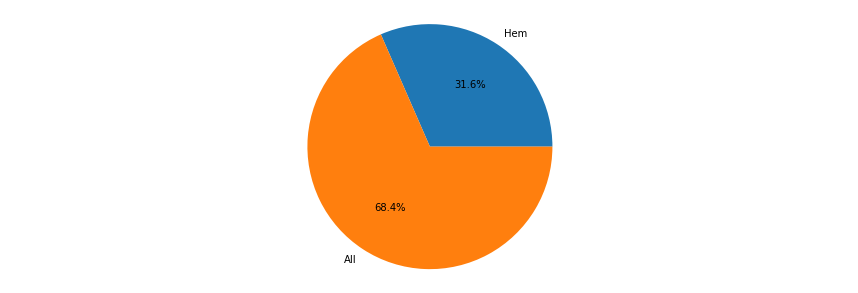

In [135]:
# Data to plot
labels, sizes = ['Hem', 'All'], [3353, 7272]

plt.figure(figsize=(15,5))
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

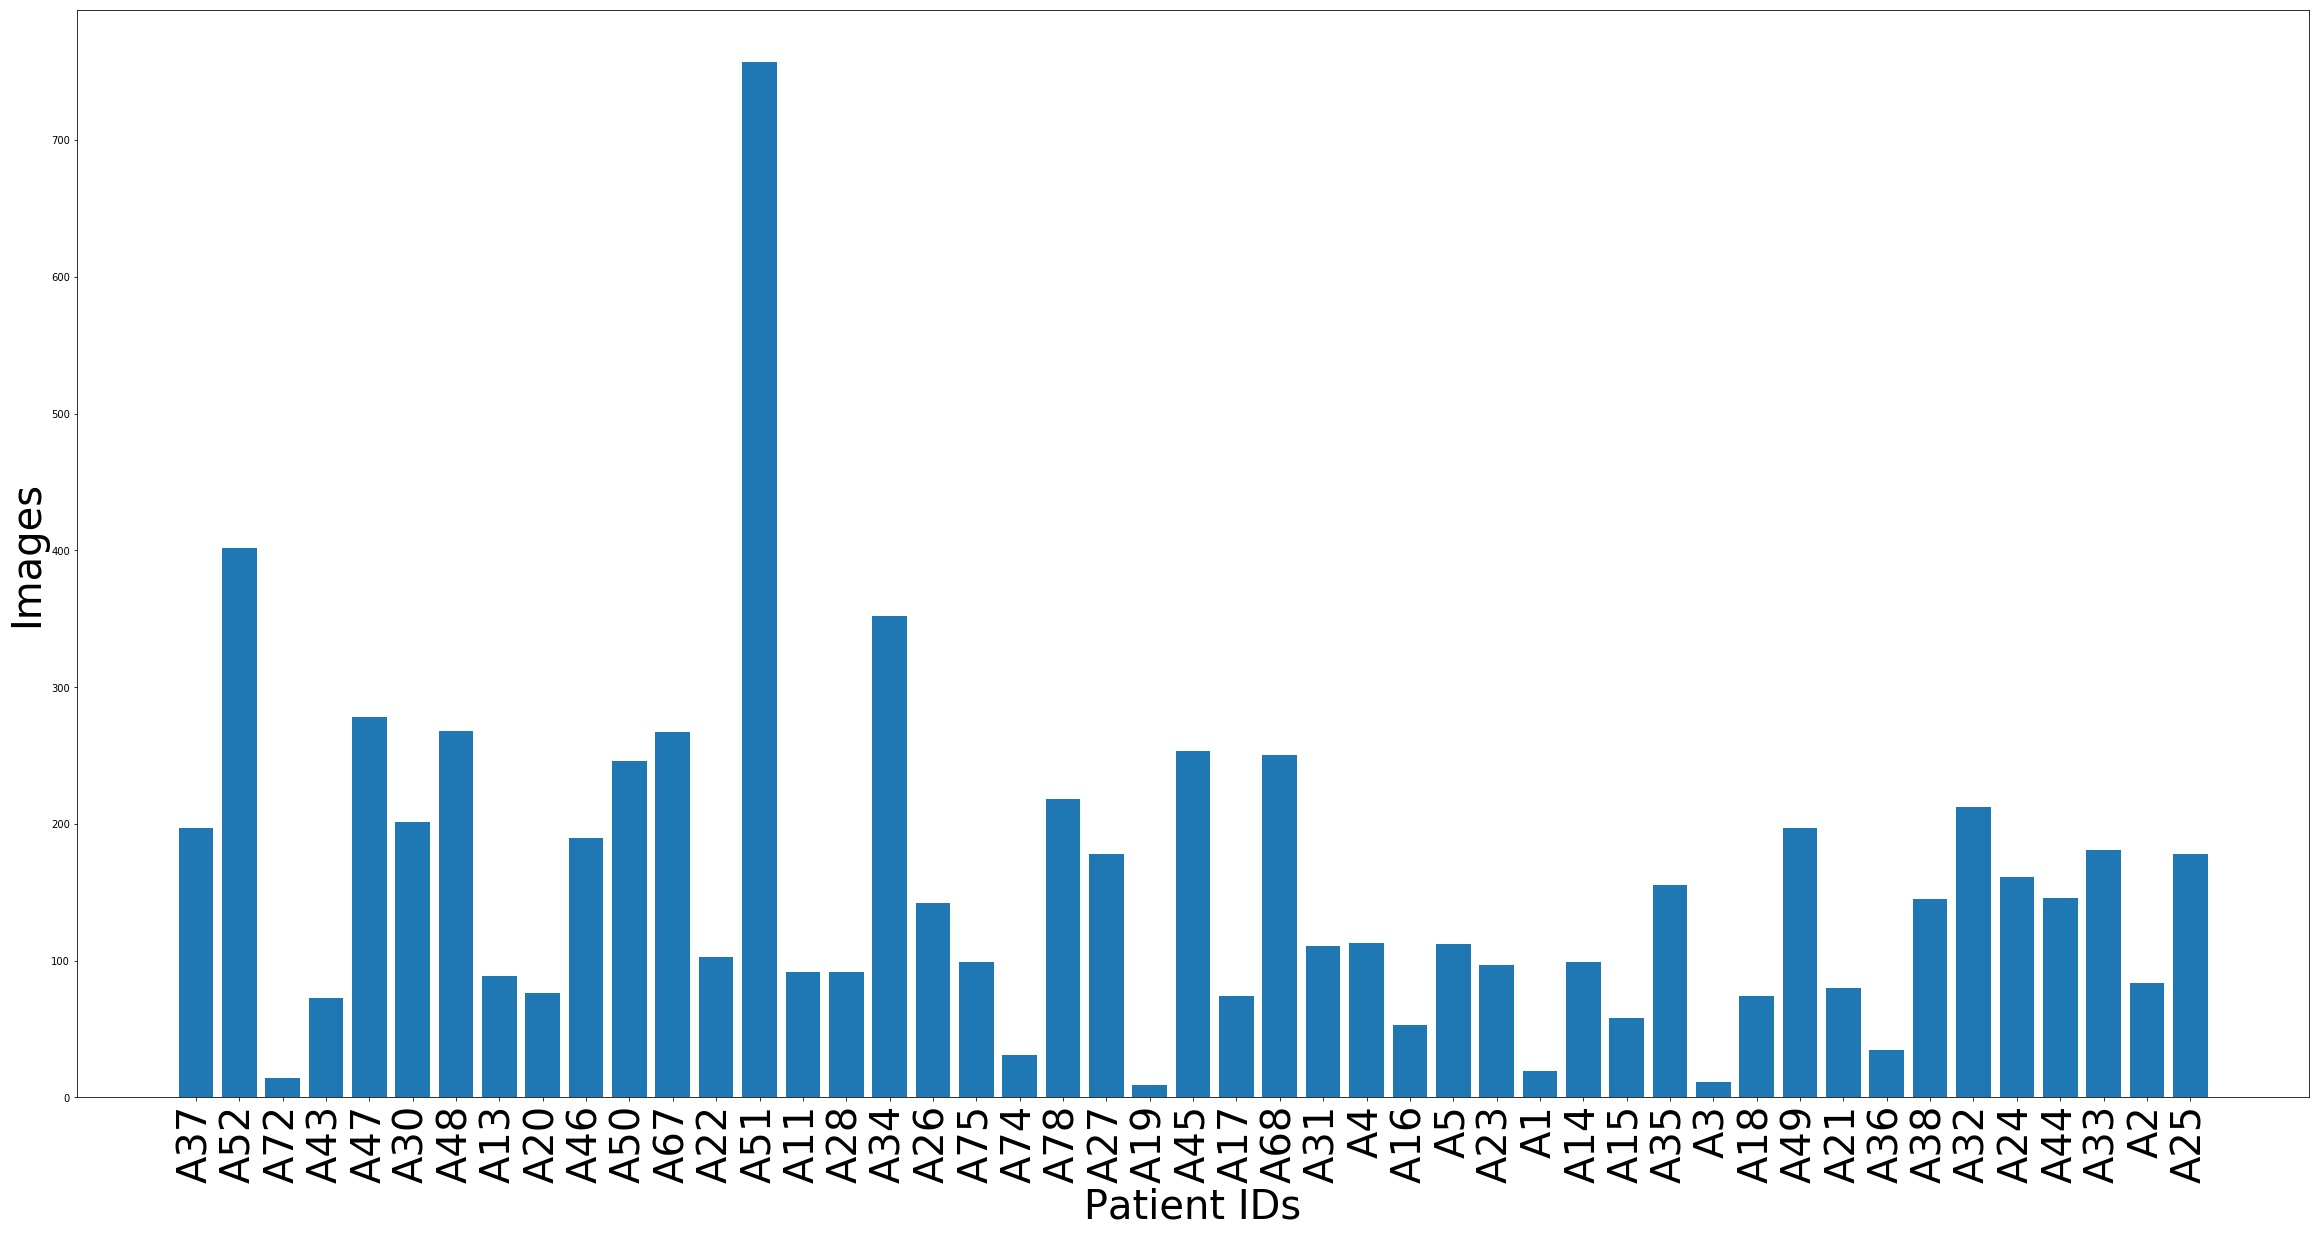

In [158]:
labels, sizes = zip(*[('A{}'.format(key), len(all_patints[key])) for key in all_patints.keys()])
x_pos = [i for i, _ in enumerate(labels)]


plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

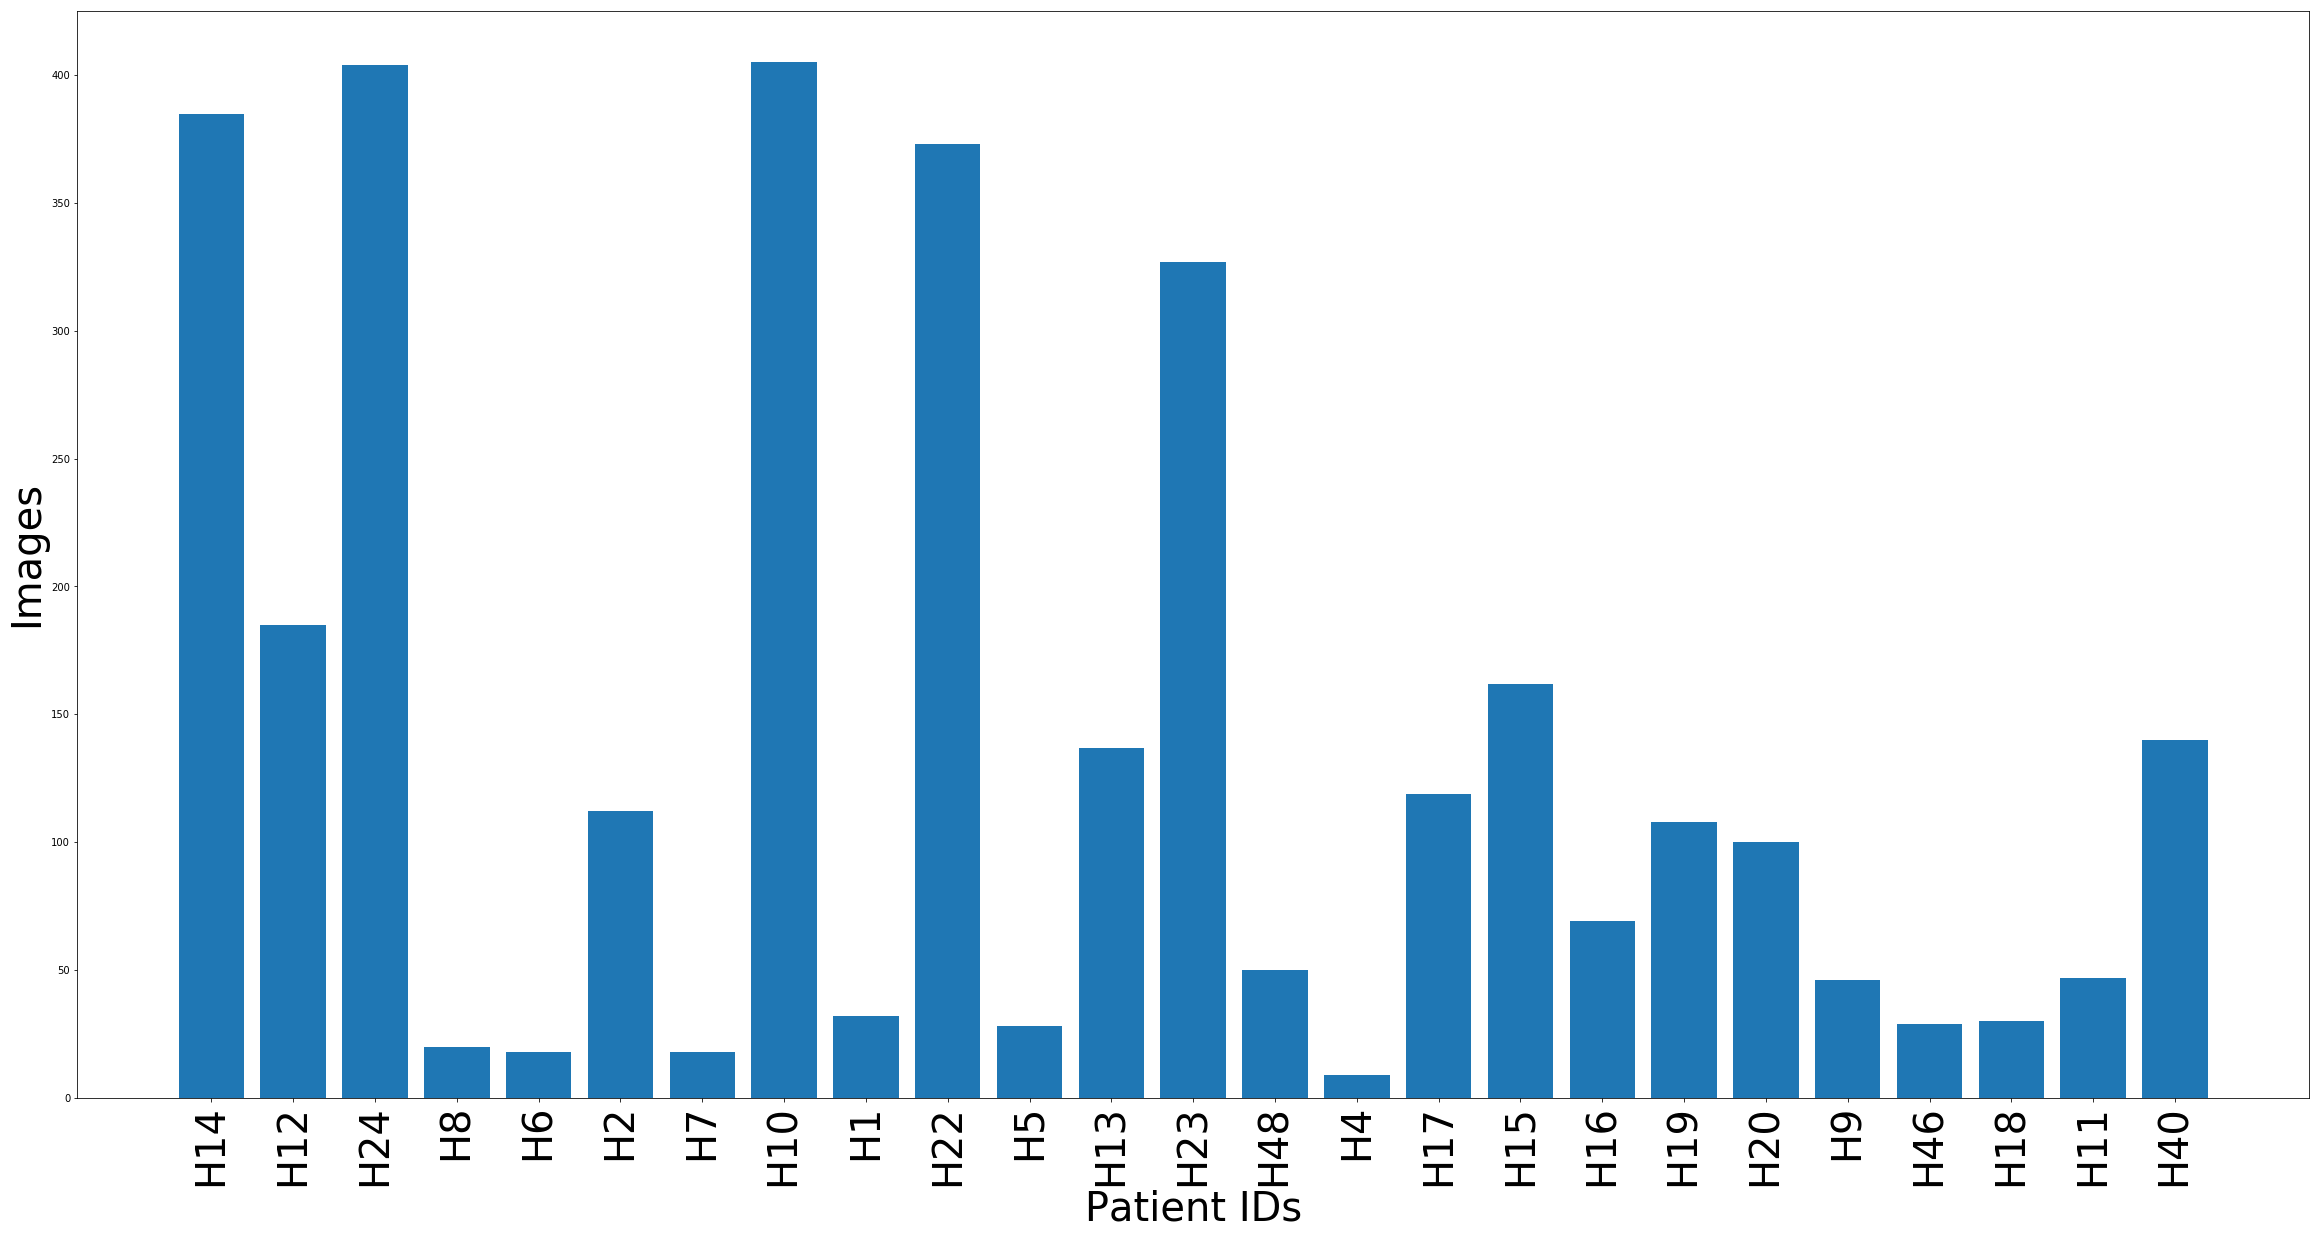

In [157]:
labels, sizes = zip(*[(key, len(hem_patients[key])) for key in hem_patients.keys()])
x_pos = [i for i, _ in enumerate(labels)]


plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

## Split data into train test 

In [200]:
class SplitByPatient:

    def __init__(self,
                 hem_patients: dict,
                 all_patients: dict):

        self.hem_patients = hem_patients
        self.all_patients = all_patients
        self.error_margin = 0.1
        self.num_trails = 100

    def random_split(self,  test_size=0.1, random_state=42):
        '''
        split files randomly
        same patient can be in train and val
        :param test_size:
        :param random_state:
        :return: hem train, all train, hem val, all val
        '''

        random.seed(random_state)

        hem_files = [self.hem_patients[key] for key in self.hem_patients.keys()]
        hem_files =[item for sublist in hem_files for item in sublist] #flatten

        all_files = [self.all_patients[key] for key in self.all_patients.keys()]
        all_files = [item for sublist in all_files for item in sublist]  # flatten

        random.shuffle(hem_files)
        random.shuffle(all_files)

        hem_split_value = int(len(hem_files) * test_size)
        all_split_value = int(len(all_files) * test_size)

        return hem_files[hem_split_value:], \
               all_files[all_split_value:], \
               hem_files[:hem_split_value], \
               all_files[:all_split_value]


    def split_by_patients(self, test_size=0.1):
        '''
        split patients randomly
        files from the same patient can not be in train and val
        :param test_size:
        :return: hem train, all train, hem val, all val
        '''

        hem_files = [self.hem_patients[key] for key in self.hem_patients.keys()]
        hem_files =[item for sublist in hem_files for item in sublist] #flatten

        all_files = [self.all_patients[key] for key in self.all_patients.keys()]
        all_files = [item for sublist in all_files for item in sublist]  # flatten

        hem_split_value = int(len(hem_files) * test_size)
        all_split_value = int(len(all_files) * test_size)

        hem_keys = list(self.hem_patients.keys())
        all_keys = list(self.all_patients.keys())

        hem_keys_train, hem_keys_val = self._split_by_patient(self.hem_patients, hem_keys, hem_split_value)
        all_keys_train, all_keys_val = self._split_by_patient(self.all_patients, all_keys, all_split_value)

        hem_files_train = [fn for fn in hem_files for key in hem_keys_train 
                           if 'UID_{0}_'.format(key) in str(fn)]
        hem_files_val = [fn for fn in hem_files for key in hem_keys_val 
                         if 'UID_{0}_'.format(key) in str(fn)]

        all_files_train = [fn for fn in all_files for key in all_keys_train 
                           if 'UID_{0}_'.format(key) in str(fn)]
        all_files_val = [fn for fn in all_files for key in all_keys_val 
                         if 'UID_{0}_'.format(key) in str(fn)]

        return hem_files_train, all_files_train, hem_files_val, all_files_val

    def split_by_regex(self, train_pat: re, val_pat: re):


        hem_files = [self.hem_patients[key] for key in self.hem_patients.keys()]
        hem_files =[item for sublist in hem_files for item in sublist] #flatten

        all_files = [self.all_patients[key] for key in self.all_patients.keys()]
        all_files = [item for sublist in all_files for item in sublist]  # flatten

        hem_train = [fn for fn in hem_files if train_pat.search(str(fn)) is not None]
        hem_val = [fn for fn in hem_files if val_pat.search(str(fn)) is not None]

        all_train = [fn for fn in all_files if train_pat.search(str(fn)) is not None]
        all_val = [fn for fn in all_files if val_pat.search(str(fn)) is not None]

        return hem_train, all_train, hem_val, all_val    
    
    
    def _split_by_patient(self, patients: dict, keys: list, split_value: int):
        count = 0
        selected_keys = []
        num_trails = 0
        while count < split_value:
            num_trails += 1
            selected_key = np.random.choice(keys, 1)[0]

            if count + len(patients[selected_key]) < split_value + split_value * self.error_margin:
                keys.remove(selected_key)
                selected_keys.append(selected_key)

                count += len(patients[selected_key])

                if num_trails > self.num_trails:
                    break

        return keys, selected_keys

In [202]:
split_handler = SplitByPatient(hem_patients, all_patints)

### Split by patient 

In [168]:
hem_train, all_train, hem_val, all_val = split_handler.split_by_patients(test_size=0.1)

### Split by regex

In [203]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

## Calc dataset intensity statistics

In [9]:
channel_mean = [0.2716068709636366, 0.11716740675990968, 0.31234732880144966]
channel_std = [0.0470964828476292, 0.03501106218376086, 0.04154600651232207]

In [224]:
green_values, red_values, blue_values = None, None, None
for path in tqdm(hem_val[:150]+all_val[:150]):

    image = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

    red_values = image[:, :, 0].flatten() if red_values is None \
        else np.concatenate((red_values, image[:, :, 0].flatten()))

    green_values = image[:, :, 1].flatten() if green_values is None \
        else np.concatenate((green_values, image[:, :, 1].flatten()))

    blue_values = image[:, :, 2].flatten() if blue_values is None \
        else np.concatenate((blue_values, image[:, :, 2].flatten()))


100%|██████████| 300/300 [00:09<00:00, 31.27it/s]


##### With zero pixel

In [225]:
channel_mean = [np.mean(red_values) / 255., np.mean(green_values) / 255., np.mean(blue_values) / 255.]
channel_std = [np.std(red_values) / 255., np.std(green_values) / 255., np.std(blue_values) / 255.]

##### Without zero pixel

In [227]:
def mean_non_zero(channel : np):
    return np.mean(channel[np.nonzero(channel)]) / 255.

def std_non_zero(channel : np):
    return np.std(channel[np.nonzero(channel)]) / 255.

channel_mean = [mean_non_zero(red_values), mean_non_zero(green_values), mean_non_zero(blue_values)]
channel_std = [std_non_zero(red_values), std_non_zero(green_values), std_non_zero(blue_values)]

In [228]:
print(channel_mean)
print(channel_std)

[0.2924981831505949, 0.13054762344214763, 0.3270776675890471]
[0.05985960989724747, 0.043419036762350025, 0.050335686496007025]


In [204]:
print('Train Total: {0}'.format(len(hem_train)+len(all_train)))
print('Val Total: {0}'.format(len(hem_val)+len(all_val)))
print("")
print('Hem train: {}'.format(len(hem_train)))
print('All train: {}'.format(len(all_train)))
print('Hem val: {}'.format(len(hem_val)))
print('All val: {}'.format(len(all_val)))

Train Total: 7108
Val Total: 3517

Hem train: 2293
All train: 4815
Hem val: 1060
All val: 2457


In [205]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

In [206]:
train = ImageItemList(hem_train+all_train)
valid = ImageItemList(hem_val + all_val)

item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

In [207]:
size = 224
bs = 128

In [229]:
data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, ds_tfms=tfms)

In [230]:
#data = data.normalize()
data = data.normalize((channel_mean, channel_std))

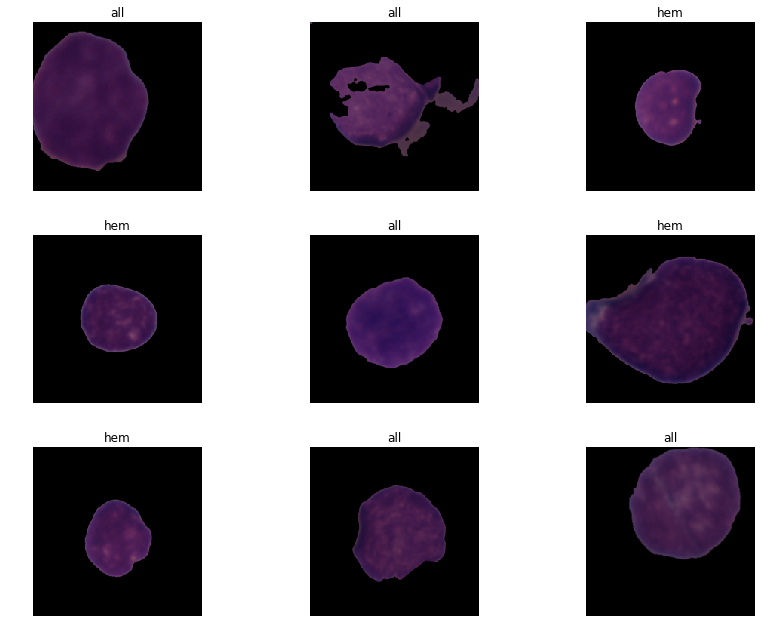

In [179]:
data.show_batch(rows=3, figsize=(12,9))

### Loss function and metrics  

In [12]:
from torch.autograd import Variable

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=1.):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, targ, reduction='none'):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = Variable(t[:, :-1].contiguous()).cuda()  # .cpu()
        x = pred[:, :-1]
        w = Variable(self.get_weight(x, t))
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [69]:
from sklearn.metrics import f1_score
class F1Weighted(Callback):

    def on_epoch_begin(self, **kwargs):
        self.y_true, self.y_pred = [], []

    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.y_pred.extend(preds.data.cpu().numpy())
        self.y_true.extend(last_target.data.cpu().numpy())

    def on_epoch_end(self, **kwargs):
        self.metric = f1_score(self.y_true, self.y_pred, average='weighted')

In [92]:
from sklearn.metrics import matthews_corrcoef
class MCC(Callback):
    '''
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
    '''

    def on_epoch_begin(self, **kwargs):
        self.y_true, self.y_pred = [], []

    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.y_pred.extend(preds.data.cpu().numpy())
        self.y_true.extend(last_target.data.cpu().numpy())

    def on_epoch_end(self, **kwargs):
        self.metric = matthews_corrcoef(self.y_true, self.y_pred)

In [231]:
learn = create_cnn(data, models.resnet34, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.5, gamma=1)
                      )

In [232]:
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (7108 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (7108 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Valid: LabelList
y: CategoryList (3517 items)
[Category hem, Category hem, Category hem, Category hem, Category hem]...
Path: .
x: ImageItemList (3517 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_si

In [22]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


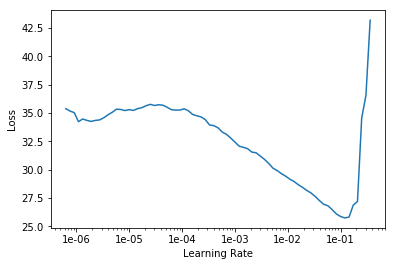

In [13]:
learn.lr_find()
learn.recorder.plot()

In [233]:
lr = 1e-2

In [234]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.469182,0.539151,0.227467,0.772533,0.459841
2,0.326729,0.501571,0.170884,0.818283,0.572031
3,0.255243,0.442261,0.141882,0.848123,0.651471
4,0.216482,0.458461,0.149844,0.839755,0.629504


## Results

In [84]:
learn.loss_func = data.loss_func
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

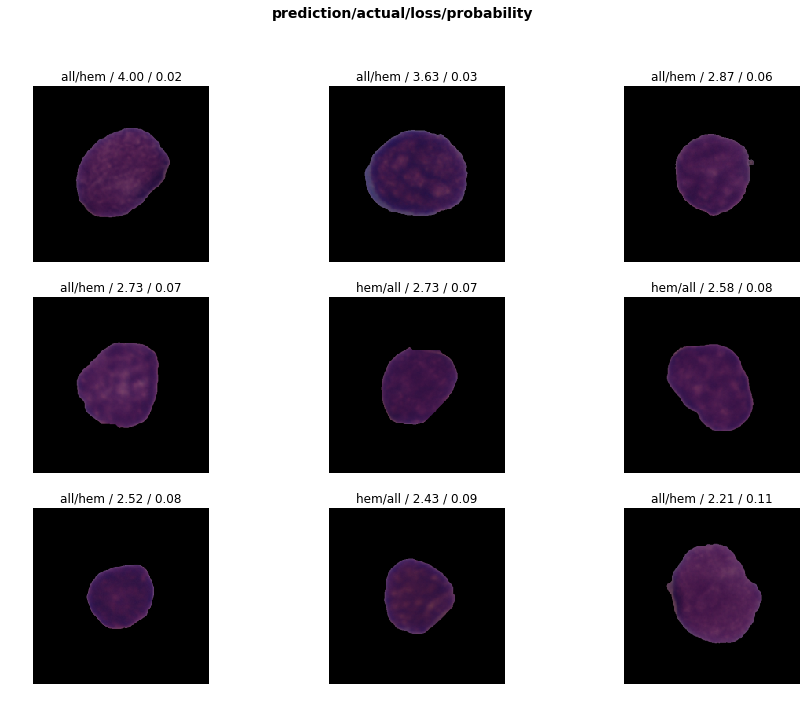

In [85]:
interp.plot_top_losses(9, figsize=(15,11))

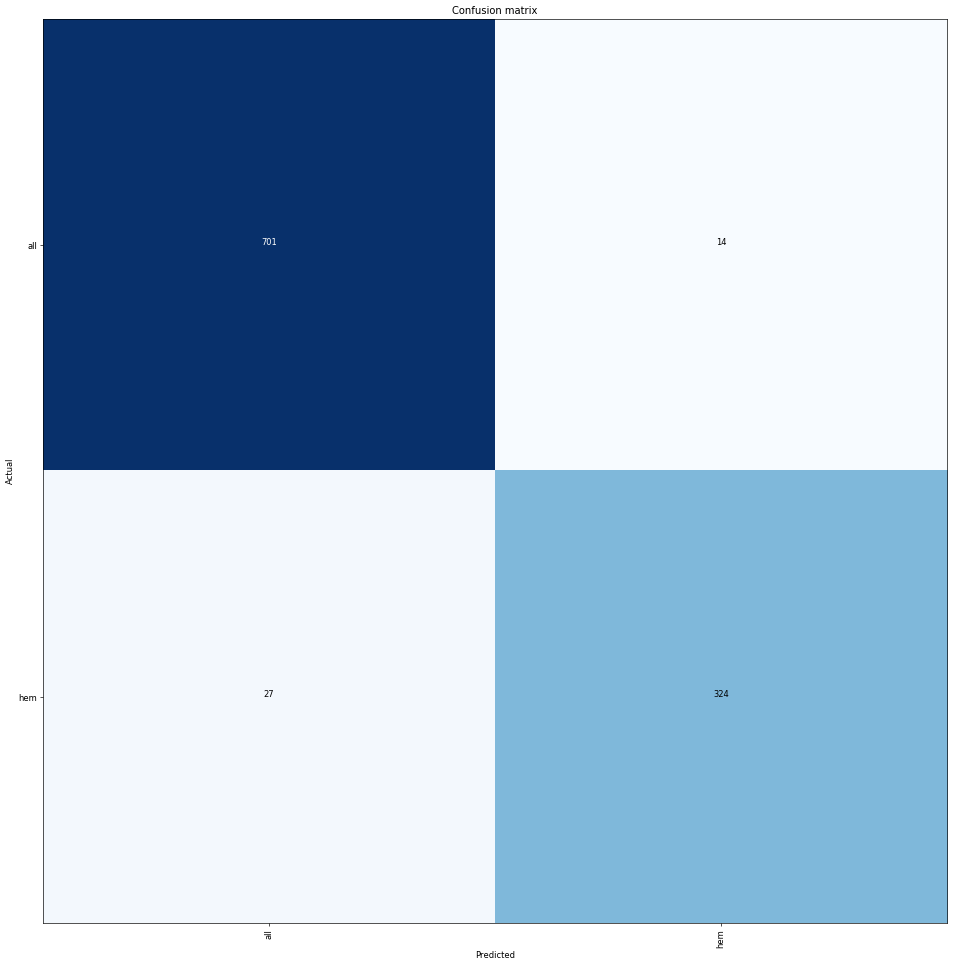

In [86]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [87]:
int(interp.confusion_matrix().flatten()[[1, 2]].sum())

41